<a href="https://colab.research.google.com/github/PavelNovikov888/PDA_vectorization_text/blob/master/vectorizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
!pip install datasets --quiet
# !pip install tokenizers==0.10.0rc1 --quiet
!pip install tokenizers
!pip install wandb --quiet

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import datasets
import tokenizers
import wandb
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

## О формате заданий

### Coding tasks


Место для вашего кода отмечено блоками `# YOUR CODE STARTS` ... `#YOUR CODE ENDS` и ваше решение должно быть строго между ними.

Чтобы решить задачу, вам придётся смотреть в документацию соответствующего фреймворка. Этот навык очень важен, и в начале мы будем намекать вам на название метода, который вам нужно использовать. Такой подход позволит плавно приблизить вас к более реалистичным задачам.



![image.png](https://files.realpython.com/media/Practical-Text-Classification-with-Keras-and-Python_Watermark.fe326bd75146.jpg)

Image source: [тык](https://realpython.com/python-keras-text-classification/)

In [144]:
text_dataset = datasets.load_dataset("imdb")

**IMDB** - это датасет по классификации эмоциональной окраски. Вам нужно предсказать положительный ли отзыв к фильму по его тексту. Это довольно простая задача и она хорошо решается даже линейными моделями. Для доступа к нему мы используем библиотеку `datasets` - она содержит в себе много интересных текстовых датасетов.

Тренировочная и тстовая части IMDB достаточно большие - каждая состоит из 25 тысяч примеров.

In [145]:
type(text_dataset['test'])

datasets.arrow_dataset.Dataset

In [146]:
text_dataset.shape

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}

In [147]:
text_dataset.column_names

{'train': ['text', 'label'],
 'test': ['text', 'label'],
 'unsupervised': ['text', 'label']}

In [148]:
text_dataset.cache_files

{'train': [{'filename': '/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/imdb-train.arrow'}],
 'test': [{'filename': '/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/imdb-test.arrow'}],
 'unsupervised': [{'filename': '/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/imdb-unsupervised.arrow'}]}

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели.

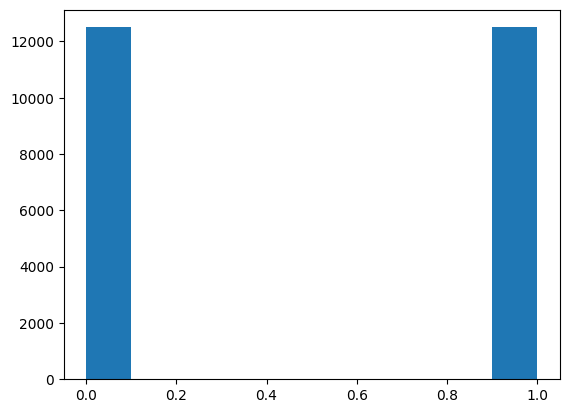

In [149]:
train_labels = [e['label'] for e in text_dataset['train']]
plt.hist(train_labels)
plt.show()

In [150]:
print(text_dataset['train']['text'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [151]:
text_dataset['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [152]:
print(text_dataset['unsupervised']['text'][0])

This is just a precious little diamond. The play, the script are excellent. I cant compare this movie with anything else, maybe except the movie "Leon" wonderfully played by Jean Reno and Natalie Portman. But... What can I say about this one? This is the best movie Anne Parillaud has ever played in (See please "Frankie Starlight", she's speaking English there) to see what I mean. The story of young punk girl Nikita, taken into the depraved world of the secret government forces has been exceptionally over used by Americans. Never mind the "Point of no return" and especially the "La femme Nikita" TV series. They cannot compare the original believe me! Trash these videos. Buy this one, do not rent it, BUY it. BTW beware of the subtitles of the LA company which "translate" the US release. What a disgrace! If you cant understand French, get a dubbed version. But you'll regret later :)


In [153]:
print(text_dataset['unsupervised']['label'][6])

-1


In [154]:
print(text_dataset['train']['text'][1])

"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we're treated to the site of Vincent Gallo's throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the same cann

In [155]:
print(text_dataset['train']['label'][1])

0


# Classification using a linear model

Линейная модель - очень сильный бейзлайн и в некоторых задачах классификации вам даже не надо идти дальше линейной модели - она уже достаточно хороша. А также её можно написать менее чем в 10 строчек. Поэтому всегда стоит начинать решение любой задачи с линейного бейзлайна.

Давайте вспомним библиотеку `sklearn` и напишем линейную модельку. Для векторизации текста мы будем использовать `TfidfVectorizer`, а в качестве модели `LogisticRegression`.


In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [157]:
# TASK 1.1: create TfidfVectorizer object and fit it on out training set texts
# Our implementation is 2 lines
# YOUR CODE STARTS
vectorizer  = TfidfVectorizer()
values = vectorizer.fit(text_dataset['train']['text'])

# YOUR CODE ENDS

In [158]:
# TASK 1.2:
# 1. convert your texts to tf-idf vectors using .transform (training texts and test texts too)
# 2. convert your labels into numpy arrays (both training and test labels)
# Or implementatin is 4 lines

# YOUR CODE STARTS
X_train = values.transform(text_dataset['train']['text'])
y_train = text_dataset['train'].with_format('numpy', columns=['label'])['label']


X_test = values.transform(text_dataset['test']['text'])
y_test = text_dataset['test'].with_format("numpy", columns=['label'])['label']
# YOUR CODE ENDS

In [159]:
type(y_train)

numpy.ndarray

In [160]:
X_train

<25000x74849 sparse matrix of type '<class 'numpy.float64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [161]:
# TASK 1.3: create LogisticRegression model object and fit the model
# Our implementation is 2 lines
# YOUR CODE STARTS
model = LogisticRegression()
model.fit(X_train, y_train)



# YOUR CODE ENDS

LogisticRegression()

А теперь мы используем нашу модель для того, чтобы предсказать классы на тестовом сете и считаем accuracy.

In [162]:
predictions = model.predict(X_test)

print(type(predictions))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [163]:
predictions

array([0, 0, 0, ..., 1, 0, 1])

In [164]:
y_test


array([0, 0, 0, ..., 1, 1, 1])

In [165]:
from sklearn.metrics import accuracy_score

In [167]:
# note that we can use vector operations, because we deal with numpy tensors
print(accuracy_score(y_test, predictions, normalize=True))
accuracy = (predictions == y_test).mean()
accuracy

0.88316


0.88316

**OMG so accurate, much machine learning**

Давайте предскажем позитивны ли такие комментарии:

In [137]:
positive_comment = 'This movie is awesome!'

vec = vectorizer.transform([positive_comment])
model.predict(vec)

array([1])

In [138]:
negative_comment = 'This movie is awful!'

vec = vectorizer.transform([negative_comment])
model.predict(vec)

array([0])

Как мы увидели, даже такая простая модель может хорошо классифицировать текст (accuracy 0.9 - это довольно много, тк выборка сбалансированна).

Кстати, использование модели LinearSVM обычно работает даже лучше, чем логистическая регрессия. Рекомендуем попробовать и сравнить.

Что такое SVM: [тык](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

Ещё один простой метод улучшить линейную модель - использовать n-gram в вашем TF-IDF. Не забудьте указать параметр `max_features` (хорошее число 50 000), а то при большом количестве фичей модель может начать переобучаться.